In [1]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import threading
import time
from timeit import default_timer as timer
from typing import Callable
plt.rcParams['figure.figsize']=(20, 10)

# Statystyka - Zestaw 3
### Autor: Konrad Ulman

In [28]:
lock = threading.Lock()
queue_pos = 0

class Task:
    def __init__(self, id, start_queue, start, end_queue = None, end = None):
        self.id = id
        self.start_queue = start_queue
        self.end_queue = end_queue
        self.start = start
        self.end = end
        
    def recalculate_time(self, time):
        self.start = self.start - time
        self.end = self.end - time
        return self
    
    def __str__(self):
        return f'Task id is {self.id}'

    def __repr__(self):
        return str(self.__dict__)
    
def producer(task_size: int, delay: float) -> list:
    global queue_pos
    
    for id in np.arange(task_size):
        time.sleep(delay)
        with lock:
            queue_pos += 1
            q_pos = queue_pos
        
        yield Task(id, q_pos, timer())
    
def consume(delay: float, task: Task) -> Task:
    global queue_pos
    
    time.sleep(delay)
    with lock:
        task.end_queue = queue_pos
        queue_pos -= 1
    
    task.end = timer()
    return task
    
def consumer(delay: float, func: Callable, *args) -> list:
    start = timer()
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        producer_logs = []
        futures = []
        done_tasks = []
        for task in func(*args):
            futures.append(executor.submit(consume, delay, task))
            
        recalculate = lambda r: r.recalculate_time(start)
        return sorted([recalculate(future.result()) for future in concurrent.futures.as_completed(futures)], key=lambda x: x.id)

In [29]:
def extract_queues(tasks: list) -> list:
    start_queue = []
    end_queue = []
    for task in tasks:
        start_queue.append(task.start_queue)
        end_queue.append(task.end_queue)
    return start_queue, end_queue

def extract_points(tasks: list) -> list:
    start = []
    end = []
    for task in tasks:
        start.append(task.start)
        end.append(task.end)
    return start, end

[5, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[0.061985699998331256, 0.11247259999800008, 0.16300760000012815, 0.21356009999726666, 0.26410109999778797, 0.3146505000004254, 0.3651852999973926, 0.41573409999909927, 0.46626370000012685, 0.5168192999990424]


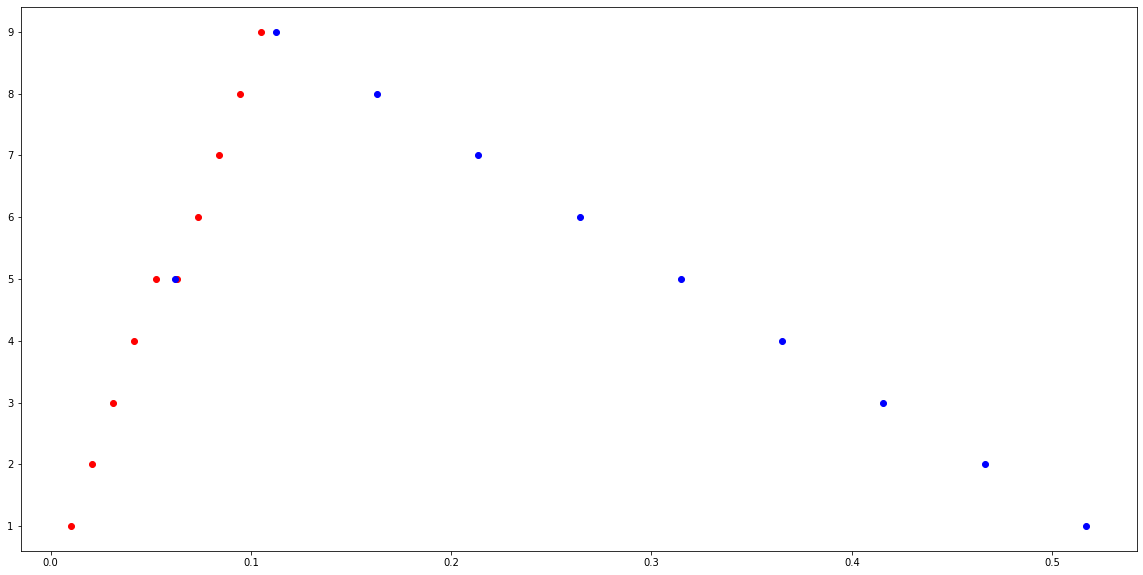

In [30]:
producer_delay = 1/100
consumer_delay = 1/20
num_of_tasks = 10

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

start_queue, end_queue = extract_queues(tasks)
start_times, end_times = extract_points(tasks)

plt.scatter(start_times, start_queue, color='r', label='$\pi_j$')
plt.scatter(end_times, end_queue, color='b', label='$\pi_j$')

plt.show()